# Automate product feedback reports using generative AI

## Overview

Going through customer review comments to generate insights for product development teams is a time intensive and costly affair. This notebook illustrates how to use DataRobot and generative AI to derive critical insights from customer reviews and automatically create improvement reports to help product teams in their development cycles. 

DataRobot provides robust Natural Language Processing capabilities in the AutoML <a href='https://www.datarobot.com/wiki/natural-language-processing/'>offering</a>. Using DataRobot AutoML models instead of plain summarization on customer reviews allows you to extract keywords that are strongly correlated with feedback. Using this impactful keyword list, Generative AI can generate user-level context around it in the user's own lingua franca for the benefit of end users. DataRobot AutoML acts as a guardrail mechanism which traditional text summarization lacks.

## Setup

### Install required libraries and dependencies

In [ ]:
!pip install "langchain==0.0.244" \
             "openai==0.27.8" \
             "datasets==2.11.0" \
             "fpdf==1.7.2"

### Import libraries 

In [ ]:
import json
import os
import warnings

import datarobot as dr
from fpdf import FPDF
from langchain.chains import LLMChain
from langchain.chat_models import AzureChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.schema import BaseOutputParser
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Configuration

Set up the configurations reuired for secure connection to the generative AI model. This notebook assumes you have an OpenAI API key, but you can modify it to work with any other hosted LLM as the process remains the same.

In [ ]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
OPENAI_ORGANIZATION = os.environ["OPENAI_ORGANIZATION"]
OPENAI_API_BASE = os.environ["OPENAI_BASE"]
OPENAI_DEPLOYMENT_NAME = os.environ["OPENAI_DEPLOYMENT_NAME"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]

In [ ]:
"""with open("/home/notebooks/storage/settings.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
OPENAI_API_KEY = config['OPENAI_API_KEY']
OPENAI_ORGANIZATION = config['OPENAI_ORGANIZATION']
OPENAI_API_BASE = config['OPENAI_BASE']
OPENAI_DEPLOYMENT_NAME = config['OPENAI_DEPLOYMENT_NAME']
OPENAI_API_VERSION = config['OPENAI_API_VERSION']
OPENAI_API_TYPE = config['OPENAI_API_TYPE']"""

'with open("/home/notebooks/storage/settings.yaml", \'r\') as stream:\n    config = yaml.safe_load(stream)\nOPENAI_API_KEY = config[\'OPENAI_API_KEY\']\nOPENAI_ORGANIZATION = config[\'OPENAI_ORGANIZATION\']\nOPENAI_API_BASE = config[\'OPENAI_BASE\']\nOPENAI_DEPLOYMENT_NAME = config[\'OPENAI_DEPLOYMENT_NAME\']\nOPENAI_API_VERSION = config[\'OPENAI_API_VERSION\']\nOPENAI_API_TYPE = config[\'OPENAI_API_TYPE\']'

### Functions and utilities

The cell below outlines the functions to accomplish the following: <br> 
- Extract high impact review keywords from product reviews using DataRobot. <br>
- During keyword extraction, implement guardrails for selecting models with higher AUC to make sure keywords are robust and correlated to the review sentiment. <br>
- Generate product development recommendations for the final report. <br>

<b>LLM Parameters:</b> Read the <a href='https://api.python.langchain.com/en/latest/llms/langchain.llms.openai.AzureOpenAI.html'>reference documentation</a> for all Azure OpenAI parameters and how they affect output.

In [ ]:
class JsonOutputParser(BaseOutputParser):
    """Parse the output of an LLM call to a Json list."""

    def parse(self, text: str):
        """Parse the output of an LLM call."""
        return json.loads(text)


def get_review_keywords(product_id):
    """Parse the Word Cloud from DataRobot AutoML model and generate the text input for the LLM."""

    keywords = ""
    product = product_subset[product_subset.product_id == product_id]
    product["review_text_full"] = product["review_headline"] + " " + product["review_body"]
    product["review_class"] = np.where(product.star_rating < 3, "bad", "good")
    project = dr.Project.create(
        product[["review_class", "review_text_full"]],
        project_name=product["product_title"].iloc[0],
    )

    """Creates a DataRobot AutoML NLP project with review text"""
    project.analyze_and_model(
        target="review_class",
        mode=dr.enums.AUTOPILOT_MODE.QUICK,
        worker_count=20,
        positive_class="good",
    )
    project.wait_for_autopilot()
    model = project.recommended_model()
    """logic to accept word ngram models and not char ngram models."""
    if max([1 if proc.find("word") != -1 else 0 for proc in model.processes]) == 0:
        models = project.get_models(order_by="-metric")
        for m in models:
            if max([1 if proc.find("word") != -1 else 0 for proc in m.processes]) == 1:
                model = m
                break
    word_cloud = model.get_word_cloud()
    word_cloud = pd.DataFrame(word_cloud.ngrams_per_class()[None])
    word_cloud.sort_values(["coefficient", "frequency"], ascending=[True, False], inplace=True)
    # keywords = '; '.join(word_cloud.head(50)['ngram'].tolist())

    """Guardrail to accept higher accuracy models, as it means the wordclouds contain \
    impactful and significant terms only """
    if model.metrics["AUC"]["crossValidation"] > 0.75:
        keywords = "; ".join(word_cloud[word_cloud.coefficient < 0]["ngram"].tolist())
    return keywords


template = f"""
    You are a product designer. A user will pass top keywords from negative customer reviews. \
    Using the keywords list, \
    provide multiple design recommendations based on the keywords to improve the sales of the product.
    Use only top 10 keywords per design recommendation.\
    
    Output Format should be json with fields recommendation_title, recommendation_description, keyword_tags"""

system_message_prompt = SystemMessagePromptTemplate.from_template(template)
human_template = "{text}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
chain = LLMChain(
    llm=AzureChatOpenAI(
        deployment_name=OPENAI_DEPLOYMENT_NAME,
        openai_api_type=OPENAI_API_TYPE,
        openai_api_base=OPENAI_API_BASE,
        openai_api_version=OPENAI_API_VERSION,
        openai_api_key=OPENAI_API_KEY,
        openai_organization=OPENAI_ORGANIZATION,
        model_name=OPENAI_DEPLOYMENT_NAME,
        temperature=0,
        verbose=True,
    ),
    prompt=chat_prompt,
    output_parser=JsonOutputParser(),
)

## Import data

This accelerator uses the publicly available Amazon Reviews dataset in this workflow. This example uses a subset of products from the Home Electronics line. The full public dataset can be found <a href='https://huggingface.co/datasets/amazon_us_reviews'>here</a>. 

You can also the individual parquet files:

* <a href='https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/amazon_us_reviews-train-00000-of-00002.parquet'>File 1</a>
* <a href='https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/amazon_us_reviews-train-00001-of-00002.parquet'>File 2</a>

In [ ]:
product_subset1 = pd.read_parquet(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/amazon_us_reviews-train-00000-of-00002.parquet"
)
product_subset2 = pd.read_parquet(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/amazon_us_reviews-train-00001-of-00002.parquet"
)
product_subset = pd.concat([product_subset1, product_subset2], axis=0)
product_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705889 entries, 0 to 31888
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        705889 non-null  object
 1   customer_id        705889 non-null  object
 2   review_id          705889 non-null  object
 3   product_id         705889 non-null  object
 4   product_parent     705889 non-null  object
 5   product_title      705889 non-null  object
 6   product_category   705889 non-null  object
 7   star_rating        705889 non-null  int32 
 8   helpful_votes      705889 non-null  int32 
 9   total_votes        705889 non-null  int32 
 10  vine               705889 non-null  int64 
 11  verified_purchase  705889 non-null  int64 
 12  review_headline    705889 non-null  object
 13  review_body        705889 non-null  object
 14  review_date        705889 non-null  object
dtypes: int32(3), int64(2), object(10)
memory usage: 78.1+ MB


In [ ]:
product_subset.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,179886,RY01SAV7HZ8QO,B00NTI0CQ2,667358431,Aketek 1080P LED Protable Projector HD PC AV V...,Home Entertainment,4,0,0,0,1,good enough for my purpose,not the best picture quality but surely suitab...,2015-08-31
1,US,37293769,R1XX8SDGJ4MZ4L,B00BUCLVZU,621695622,TiVo Mini with IR Remote (Old Version),Home Entertainment,5,0,0,0,0,Tell the Cable Company to Keep their Boxes!,Not only do my TiVo Minis replace the boxes th...,2015-08-31
2,US,8332121,R149Q3B5L33NN5,B00RBX9D5W,143071132,Apple TV MD199LL/A Bundle including remote and...,Home Entertainment,5,0,0,0,1,Works perfectly!,Works perfectly! Very user friendly!,2015-08-31
3,US,47054962,R2ZVD69Z6KPJ4O,B00UJ3IULO,567816707,New Roku 3 6.5 Foot HDMI - Bundle - v1,Home Entertainment,1,0,2,0,1,It doesn't work. Each time I try to use ...,"It doesn't work. Each time I try to use it, th...",2015-08-31
4,US,23413911,R1DIKG2G33ZLNP,B0037UCTXG,909557698,Generic DVI-I Dual-Link (M) to 15-Pin VGA (F) ...,Home Entertainment,4,0,0,0,1,As pictured,I received the item pictured. I am unsure why...,2015-08-31


## Report generation loop

This programmatic loop runs through the product list and generates the final report.

In [ ]:
from datetime import datetime

In [ ]:
product_list = ["B000204SWE", "B00EUY59Z8", "B006U1YUZE", "B00752R4PK", "B004OF9XGO"]

pdf = FPDF()
for product_id in product_list:
    print(
        "product id:",
        product_id,
        "started:",
        datetime.now().strftime("%m-%d-%y %H:%M:%S"),
    )
    keywords = get_review_keywords(product_id)
    """ Guardrail to generate report only if there are enough \
        Keywords to provide results"""
    if len(keywords) > 10:
        # report = chain.run(keywords)['recommendations']
        report = chain.run(keywords)
        if type(report) != list:
            report = chain.run(keywords)["recommendations"]
        product_name = product_subset[product_subset.product_id == product_id][
            "product_title"
        ].iloc[0]
        print("Adding to report")
        pdf.add_page()
        pdf.set_font("Arial", "B", 20)
        pdf.multi_cell(w=0, h=10, txt=product_name)
        for reco in report:
            pdf.cell(w=0, h=7, txt="\n", ln=1)
            pdf.set_font("Arial", "B", 14)
            pdf.multi_cell(w=0, h=7, txt=reco["recommendation_title"])
            pdf.set_font("Arial", "", 14)
            pdf.multi_cell(w=0, h=7, txt=reco["recommendation_description"])
            pdf.set_font("Arial", "I", 11)
            pdf.multi_cell(w=0, h=5, txt="Review Keywords: " + ", ".join(reco["keyword_tags"]))
    print(
        "product id:",
        product_id,
        "completed:",
        datetime.now().strftime("%m-%d-%y %H:%M:%S"),
    )
pdf.output(f"/home/notebooks/storage/product_development_insights.pdf", "F")

### Download the report

Download the pdf named "product_development_insights.pdf" at "/home/notebooks/storage/" or from the notebook files tab in the UI Panel.

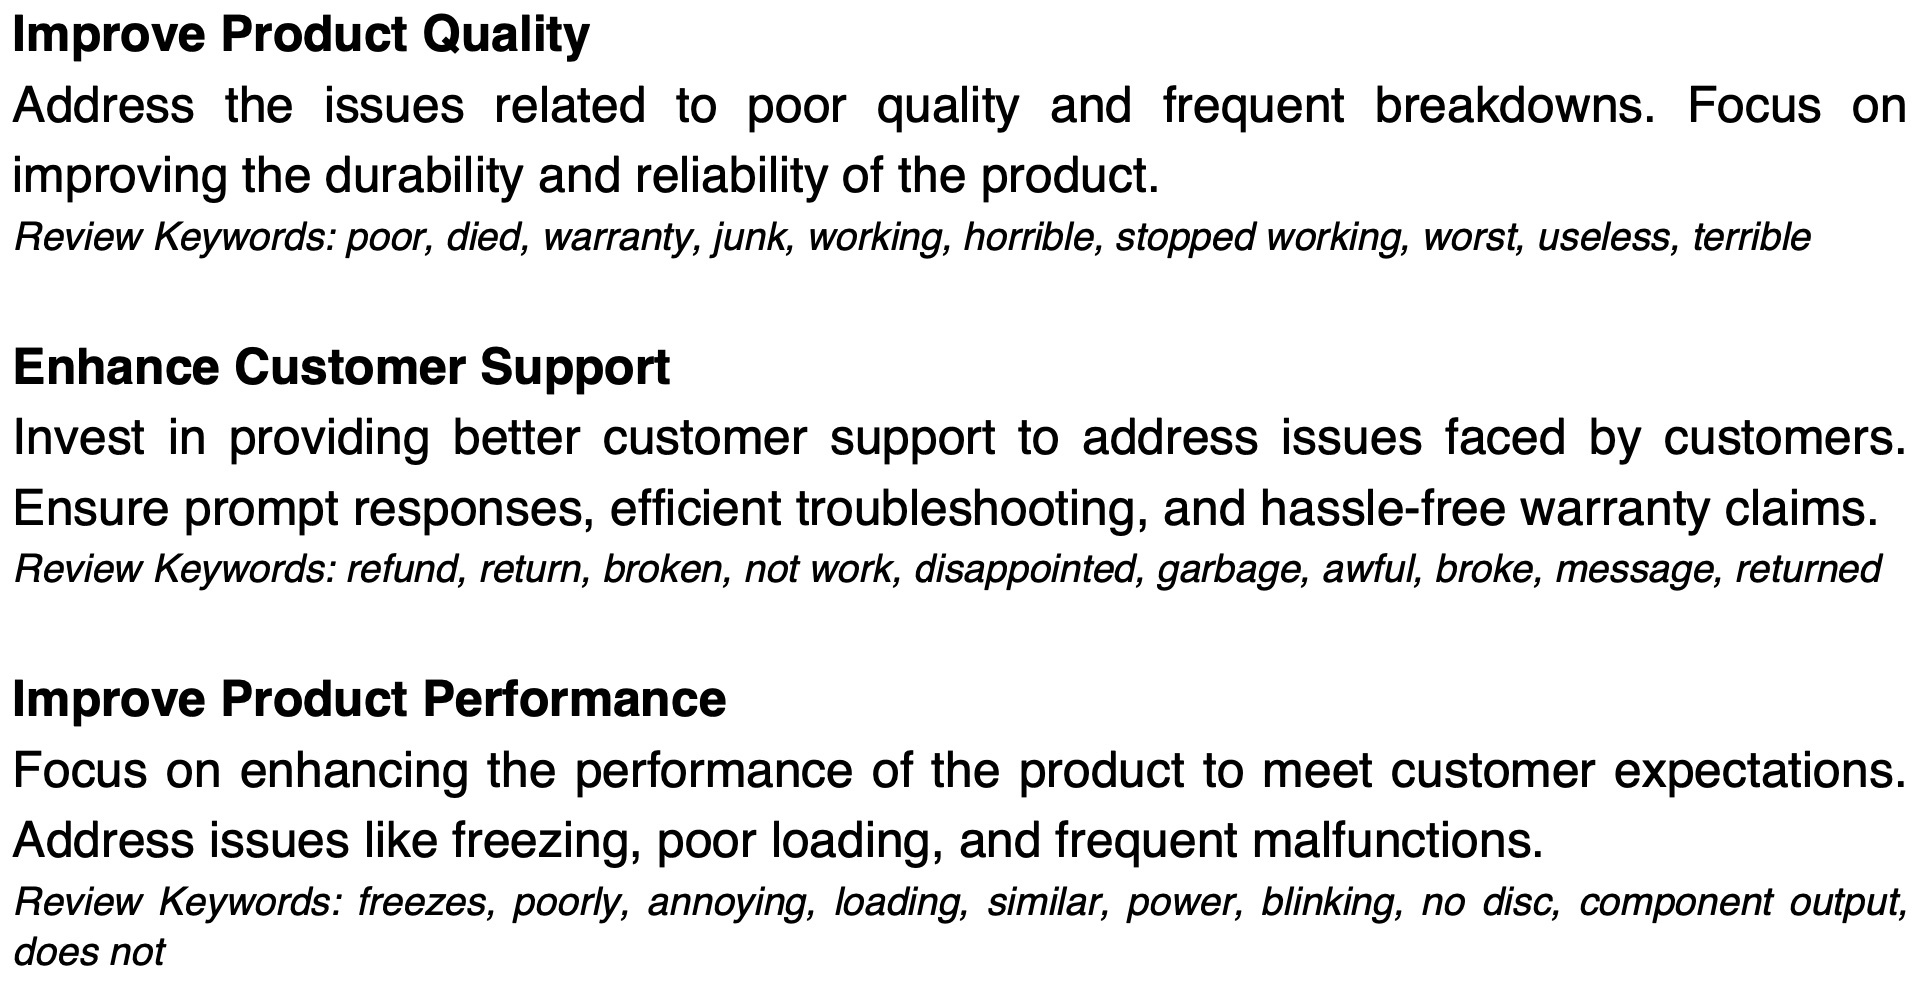

In [ ]:
from IPython import display

display.Image(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/images/image_report.jpg",
    width=800,
    height=400,
)

## Conclusion

This accelerator demonstrates how you can use DataRobot and generative AI to identify key patterns in customer reviews and create reports or work items that can be used by product development teams to improve their products and offerings. Using various prompts you can steer the LLM into much more complex outputs like Agile stories, development plans, and more.